## METODOLOGÍA DE ESTIMACIÓN DE POBLACIÓN FOTANTE 
### Comuna de Providencia

> **Autor** \
> Janus Leonhardt \
> Estudiante Ingeniería Civil Industrial en Transporte UC \
> jaleonhardt@uc.cl \
> @j.leonhardt

Con el objetivo de presentar una metodología para la estimación de la población flotante en la comuna de Providencia, se presenta a continuación una herramienta basada en Sistemas de Información Geográfica (SIG), en Python 3.7. Para ello, se contemplan las librerías Pandas, GeoPandas, MatPlotLib, Shapely, Numpy, StatsModels, Seaborn, Contextily, entre otras. En caso de no tener preinstalada alguna de las librerías señaladas, se sugiere hacerlo a través del comando "pip3 install nombre_librería".

### 1. INSTALACIÓN DE LIBRERÍAS

In [1]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot
from shapely.geometry import Point, Polygon
#from shapely.ops import cascaded_union
import numpy as np
from math import exp as e
from Herramientas import teselator as ts
from shapely import wkt
import statsmodels.api as sm
import seaborn as sns
import contextily as ctx
pd.options.mode.chained_assignment = None

### 2. CAPTURA DE LOS METROS CUADRADOS DE USOS DE SUELO POR MANZANA SII

A partir del Detalle Catastral del Servicio de Impuestos Internos (SII), agregado a nivel nacional e histórico, se procede a continuación a capturar la información de los metros cuadrados de usos de suelo por Manzana SII, dentro de la comuna de Providencia, hasta el año 2012. Esto permitirá entender las dinámicas de los usos de suelo de la comuna de Providencia al 2012, de manera tal de sentar las bases del estudio correspondiente.

El Detalle Catastral se obtiene a partir de https://www4.sii.cl/sismunInternet/?caller=DETALLE_CAT_Y_ROL_COBRO. Esta página contiene información referencial, la cual se actualiza periódicamente, por lo que, al momento de ser consultada podría presentar diferencias en relación a lo obtenido al momento de elaborar el presente estudio.

En términos del código propuesto, se contemplan las siguientes funciones:
- read_SII(año): Se encarga de leer la información del Detalle Catastral del SII, contenida en los archivos "Predio.txt" y "Linea.txt", recopilando hasta el corte temporal establecido por "año". En este caso en específico, se define "año" = 2011, de manera tal de contar con la información de los usos de suelo de la comuna de Providencia al inicio del 2012. Se retornan los DataFrame df_predios y df_lineas, con la información respectiva.

- info_SII(df_predios, df_lineas): A partir de los DataFrame df_predios y df_lineas, esta función se encarga de caracterizar cada Manzana SII, en términos de su superficie total y su superficie por cada uso de suelo respectivo. Cabe precisar que la información de las líneas de construcción, utilizada para la estimación de la superficie de cada uso de suelo por Manzana SII, considera los metros cuadrados en altura, ante lo cual la superficie total de la manzana será siempre menor o igual a la suma de la superficie de todos los usos de suelo registrados en la Manzana SII respectiva. Se retorna el DataFrame df_predios con la información respectiva.

In [2]:
def read_SII (año):
    df_predios = pd.read_csv('Inputs/SII/Predio.txt',sep='|',encoding='cp1252',header=None)
    df_lineas = pd.read_csv('Inputs/SII/Linea.txt',sep='|',encoding='cp1252',header=None)
    df_predios = df_predios.loc[(df_predios[0] == 15103)]
    df_lineas = df_lineas.loc[(df_lineas[0] == 15103)&(df_lineas[6] <= año)]
    return df_predios, df_lineas
    
def info_SII (df_predios, df_lineas):
    df_lineas2 = (df_lineas.groupby([1,8]).aggregate({7: 'sum'}).reset_index())
    df_lineas2.columns = ['MANZ_SII','USO_SUELO','SUPERFICIE_L']
    df_predios2 = (df_predios.groupby([1]).aggregate({14: 'sum'}).reset_index())
    df_predios2.columns = ['MANZ_SII','SUPERFICIE_P']
    df_predios2 = df_predios2.merge(df_lineas2, on=['MANZ_SII'])
    df_predios2['COMERCIO'] = df_predios2.apply(lambda row: row['SUPERFICIE_L'] if (row['USO_SUELO'] == 'C') else 0, axis = 1)
    df_predios2['DEPORTE_RECREACION'] = df_predios2.apply(lambda row: row['SUPERFICIE_L'] if (row['USO_SUELO'] == 'D') else 0, axis = 1)
    df_predios2['EDUCACION_CULTURA'] = df_predios2.apply(lambda row: row['SUPERFICIE_L'] if (row['USO_SUELO'] == 'E') else 0, axis = 1)
    df_predios2['HOTEL_MOTEL'] = df_predios2.apply(lambda row: row['SUPERFICIE_L'] if (row['USO_SUELO'] == 'G') else 0, axis = 1)
    df_predios2['HABITACIONAL'] = df_predios2.apply(lambda row: row['SUPERFICIE_L'] if (row['USO_SUELO'] == 'H') else 0, axis = 1)
    df_predios2['INDUSTRIA'] = df_predios2.apply(lambda row: row['SUPERFICIE_L'] if (row['USO_SUELO'] == 'I') else 0, axis = 1)
    df_predios2['BODEGA'] = df_predios2.apply(lambda row: row['SUPERFICIE_L'] if (row['USO_SUELO'] == 'L') else 0, axis = 1)
    df_predios2['MINERIA'] = df_predios2.apply(lambda row: row['SUPERFICIE_L'] if (row['USO_SUELO'] == 'M') else 0, axis = 1)
    df_predios2['OFICINA'] = df_predios2.apply(lambda row: row['SUPERFICIE_L'] if (row['USO_SUELO'] == 'O') else 0, axis = 1)
    df_predios2['ADMINISTRACION_PUBLICA'] = df_predios2.apply(lambda row: row['SUPERFICIE_L'] if (row['USO_SUELO'] == 'P') else 0, axis = 1)
    df_predios2['CULTO'] = df_predios2.apply(lambda row: row['SUPERFICIE_L'] if (row['USO_SUELO'] == 'Q') else 0, axis = 1)
    df_predios2['SALUD'] = df_predios2.apply(lambda row: row['SUPERFICIE_L'] if (row['USO_SUELO'] == 'S') else 0, axis = 1)
    df_predios2['TRANSPORTE'] = df_predios2.apply(lambda row: row['SUPERFICIE_L'] if (row['USO_SUELO'] == 'T') else 0, axis = 1)
    df_predios2['OTROS'] = df_predios2.apply(lambda row: row['SUPERFICIE_L'] if (row['USO_SUELO'] == 'V') else 0, axis = 1)
    df_predios2['ESTACIONAMIENTOS'] = df_predios2.apply(lambda row: row['SUPERFICIE_L'] if (row['USO_SUELO'] == 'Z') else 0, axis = 1)
    df_predios = (df_predios2.groupby(['MANZ_SII','SUPERFICIE_P']).aggregate({'COMERCIO': 'sum','DEPORTE_RECREACION': 'sum','EDUCACION_CULTURA': 'sum','HOTEL_MOTEL': 'sum','HABITACIONAL': 'sum','INDUSTRIA': 'sum','BODEGA': 'sum','MINERIA': 'sum','OFICINA': 'sum','ADMINISTRACION_PUBLICA': 'sum','CULTO': 'sum','SALUD': 'sum','TRANSPORTE': 'sum','OTROS': 'sum','ESTACIONAMIENTOS': 'sum'}).reset_index())
    return df_predios

In [3]:
df_predios, df_lineas = read_SII(2011)
df_predios = info_SII(df_predios, df_lineas)

### 3. VINCULACIÓN DE INFORMACIÓN DE MANZANA SII CON SHAPE DE PROVIDENCIA

Luego de caracterizar cada Manzana SII de Providencia al 2012, se procede a continuación a georreferenciar esta información con el archivo .shp disponible de la comuna, con el objetivo de mapear las dinámicas de los usos de suelo. Tras finalizar la ejecución de este código, se obtiene el archivo "UsosdeSuelo_Providencia2012.shp", que puede ser analizado en profundidad a través de GeoPandas, o bien en softwares como ArcGis Pro o QGIS.

En términos del código propuesto, se contemplan las siguientes funciones:
- geom_SII(comuna): A partir del "Shape_SantiagoOriente", esta función extrae la geoinformación de "comuna", siendo en este caso Providencia, y define la geometría respectiva a la zonificación por Manzana SII. Retorna el GeoDataFrame gdf_mz_providencia con la información respectiva.

- geoInfo_SII(df_predios, gdf_mz_providencia): Recibe el DataFrame df_predios y el GeoDataFrame gdf_mz_providencia para traspasar la información de cada Manzana SII, contenida en df_predios, al Shape respectivo, contenido en gdf_mz_providencia. Retorna el GeoDataFrame gdf_mz_providencia con la información actualizada.

In [4]:
def geom_SII (comuna):
    bd_mz_providencia = 'Inputs/Shapes/Shape_SantiagoOriente.shp'
    gdf_mz_providencia = gpd.read_file(bd_mz_providencia)
    gdf_mz_providencia = gdf_mz_providencia.loc[gdf_mz_providencia['COMUNA']==comuna]
    gdf_mz_providencia['AREA'] = gdf_mz_providencia['geometry'].area
    df_mz_providencia = pd.DataFrame(gdf_mz_providencia)
    df_mz_providencia['geometry'] = df_mz_providencia.geometry.apply(lambda x: wkt.dumps(x))
    gdf_mz_providencia = (df_mz_providencia.groupby(['COMUNA','MANZ_SII','NOM_COMUNA','CMN_MZ','geometry']).aggregate({'AREA': 'sum'}).reset_index())
    gdf_mz_providencia['geometry'] = gdf_mz_providencia['geometry'].apply(wkt.loads)
    gdf_mz_providencia = gpd.GeoDataFrame(gdf_mz_providencia, geometry='geometry')
    return gdf_mz_providencia

def geoInfo_SII (df_predios, gdf_mz_providencia):
    gdf_mz_providencia = gdf_mz_providencia.merge(df_predios, how='left', on=['MANZ_SII'])
    gdf_mz_providencia['COMERCIO'] = gdf_mz_providencia['COMERCIO'].fillna(0)
    gdf_mz_providencia['DEPORTE_RECREACION'] = gdf_mz_providencia['DEPORTE_RECREACION'].fillna(0)
    gdf_mz_providencia['EDUCACION_CULTURA'] = gdf_mz_providencia['EDUCACION_CULTURA'].fillna(0)
    gdf_mz_providencia['HOTEL_MOTEL'] = gdf_mz_providencia['HOTEL_MOTEL'].fillna(0)
    gdf_mz_providencia['HABITACIONAL'] = gdf_mz_providencia['HABITACIONAL'].fillna(0)
    gdf_mz_providencia['INDUSTRIA'] = gdf_mz_providencia['INDUSTRIA'].fillna(0)
    gdf_mz_providencia['BODEGA'] = gdf_mz_providencia['BODEGA'].fillna(0)
    gdf_mz_providencia['MINERIA'] = gdf_mz_providencia['MINERIA'].fillna(0)
    gdf_mz_providencia['OFICINA'] = gdf_mz_providencia['OFICINA'].fillna(0)
    gdf_mz_providencia['ADMINISTRACION_PUBLICA'] = gdf_mz_providencia['ADMINISTRACION_PUBLICA'].fillna(0)
    gdf_mz_providencia['CULTO'] = gdf_mz_providencia['CULTO'].fillna(0)
    gdf_mz_providencia['SALUD'] = gdf_mz_providencia['SALUD'].fillna(0)
    gdf_mz_providencia['TRANSPORTE'] = gdf_mz_providencia['TRANSPORTE'].fillna(0)
    gdf_mz_providencia['OTROS'] = gdf_mz_providencia['OTROS'].fillna(0)
    gdf_mz_providencia['ESTACIONAMIENTOS'] = gdf_mz_providencia['ESTACIONAMIENTOS'].fillna(0)
    gdf_mz_providencia.set_crs(epsg=32719, inplace=True)
    gdf_mz_providencia.to_crs(epsg=3857, inplace=True)
    return gdf_mz_providencia

In [5]:
gdf_mz_providencia = geom_SII(15103)
gdf_mz_providencia = geoInfo_SII(df_predios, gdf_mz_providencia)
gdf_mz_providencia.to_file('Outputs/Información_ManzanaSII_2012/Información_ManzanaSII_2012.shp')

### 4. ZONIFICACIÓN POR CELDAS HEXAGONALES

Con el objetivo de capturar la información de toda la comuna de Providencia, incluyendo las vialidades, se procede a zonificar a través de celdas hexagonales de diámetro de 400 metros. Cada una de estas celdas contendrá la información de los usos de suelo de las Manzanas SII que intersecta, de acuerdo al corte temporal del 2012 establecido previamente.

En términos del código propuesto, se contempla la siguiente función:
- cells_Providencia(gdf_mz_providencia): A partir del GeoDataFrame gdf_mz_providencia, se encarga de generar la zonificación por celdas hexagonales y traspasar toda la información a estas, retornando un GeoDataFrame denominado "celdas_providencia". Comienza por definir los límites de la comuna de Providencia, luego define la holgura de cada celda hexagonal, procediendo a su creación y a la asignación de la información de los indicadores respectivos.


In [6]:
def cells_Providencia (gdf_mz_providencia):
    xmin, ymin, xmax, ymax = gdf_mz_providencia.total_bounds
    holg_x = 100
    holg_y = 100
    largo_hex = 200
    epsg_providencia = 3857
    celdas_providencia = ts.hexagon_teselation(xmin - holg_x, xmax + holg_x, ymin - holg_y, ymax + holg_y, side=largo_hex, epsg=epsg_providencia)
    celdas_poligonos = celdas_providencia['geometry']
    zonas_prov_polig = gdf_mz_providencia['geometry']

    COMERCIO_list = list()
    DEPORTE_RECREACION_list = list()
    EDUCACION_CULTURA_list = list()
    HOTEL_MOTEL_list = list()
    HABITACIONAL_list = list()
    INDUSTRIA_list = list()
    BODEGA_list = list()
    OFICINA_list = list()
    ADMINISTRACION_PUBLICA_list = list()
    CULTO_list = list()
    SALUD_list = list()
    TRANSPORTE_list = list()
    OTROS_list = list()
    ESTACIONAMIENTOS_list = list()

    for i, rows in celdas_providencia.iterrows():
        pol_i = rows['geometry']
        COMERCIO_val = 0
        DEPORTE_RECREACION_val = 0
        EDUCACION_CULTURA_val = 0
        HOTEL_MOTEL_val = 0
        HABITACIONAL_val = 0
        INDUSTRIA_val = 0
        BODEGA_val = 0
        OFICINA_val = 0
        ADMINISTRACION_PUBLICA_val = 0
        CULTO_val = 0
        SALUD_val = 0
        TRANSPORTE_val = 0
        OTROS_val = 0
        ESTACIONAMIENTOS_val = 0

        for j, row_manz in gdf_mz_providencia.iterrows():    
            if pol_i.intersects(row_manz['geometry']):
                id_manzana = row_manz['MANZ_SII']
                area_intersec = pol_i.intersection(row_manz['geometry']).area
                area_manz = row_manz['geometry'].area
                porc_area = area_intersec / area_manz
                COMERCIO_val += porc_area * row_manz['COMERCIO']
                DEPORTE_RECREACION_val += porc_area * row_manz['DEPORTE_RECREACION']
                EDUCACION_CULTURA_val += porc_area * row_manz['EDUCACION_CULTURA']
                HOTEL_MOTEL_val += porc_area * row_manz['HOTEL_MOTEL']
                HABITACIONAL_val += porc_area * row_manz['HABITACIONAL']
                INDUSTRIA_val += porc_area * row_manz['INDUSTRIA']
                BODEGA_val += porc_area * row_manz['BODEGA']
                OFICINA_val += porc_area * row_manz['OFICINA']
                ADMINISTRACION_PUBLICA_val += porc_area * row_manz['ADMINISTRACION_PUBLICA']
                CULTO_val += porc_area * row_manz['CULTO']
                SALUD_val += porc_area * row_manz['SALUD']
                TRANSPORTE_val += porc_area * row_manz['TRANSPORTE']
                OTROS_val += porc_area * row_manz['OTROS']
                ESTACIONAMIENTOS_val += porc_area * row_manz['ESTACIONAMIENTOS']

        COMERCIO_list.append(COMERCIO_val)
        DEPORTE_RECREACION_list.append(DEPORTE_RECREACION_val)
        EDUCACION_CULTURA_list.append(EDUCACION_CULTURA_val)
        HOTEL_MOTEL_list.append(HOTEL_MOTEL_val)
        HABITACIONAL_list.append(HABITACIONAL_val)
        INDUSTRIA_list.append(INDUSTRIA_val)
        BODEGA_list.append(BODEGA_val)
        OFICINA_list.append(OFICINA_val)
        ADMINISTRACION_PUBLICA_list.append(ADMINISTRACION_PUBLICA_val)
        CULTO_list.append(CULTO_val)
        SALUD_list.append(SALUD_val)
        TRANSPORTE_list.append(TRANSPORTE_val)
        OTROS_list.append(OTROS_val)
        ESTACIONAMIENTOS_list.append(ESTACIONAMIENTOS_val)

    celdas_providencia['COMERCIO'] = COMERCIO_list
    celdas_providencia['DEPORTE_RECREACION'] = DEPORTE_RECREACION_list
    celdas_providencia['EDUCACION_CULTURA'] = EDUCACION_CULTURA_list
    celdas_providencia['HOTEL_MOTEL'] = HOTEL_MOTEL_list
    celdas_providencia['HABITACIONAL'] = HABITACIONAL_list
    celdas_providencia['INDUSTRIA'] = INDUSTRIA_list
    celdas_providencia['BODEGA'] = BODEGA_list
    celdas_providencia['OFICINA'] = OFICINA_list
    celdas_providencia['ADMINISTRACION_PUBLICA'] = ADMINISTRACION_PUBLICA_list
    celdas_providencia['CULTO'] = CULTO_list
    celdas_providencia['SALUD'] = SALUD_list
    celdas_providencia['TRANSPORTE'] = TRANSPORTE_list
    celdas_providencia['OTROS'] = OTROS_list
    celdas_providencia['ESTACIONAMIENTOS'] = ESTACIONAMIENTOS_list
    return celdas_providencia

In [7]:
celdas_providencia = cells_Providencia(gdf_mz_providencia)

### 5. CREACIÓN DE BUFFERS POR VIAJES ATRAÍDOS

A partir de la información presentada en la Encuesta Origen-Destino 2012 (EOD 2012), se procede a georreferenciar el total de viajes atraídos a Providencia, que proceden de otras comunas de la Región Metropolitana y cuyo propósito de viaje difiere del "Retorno al Hogar". A partir de la georreferenciación de la EOD 2012, se genera un buffer de 400 metros de diámetro, con el objetivo de ilustrar la zona de influencia de los usuarios.

En términos del código propuesto, se contemplan la siguiente funciones:
- decode_column(df, fname, col_name, ...): Se encarga de decodificar cada columna del DataFrame "viajes", que contiene la información recopilada de la EOD 2012. Devuelve los valores de la columna respectiva que se desea decodificar.

- read_EOD(): Utilizando decode_column(...), se encarga de leer la EOD 2012 y retornar el DataFrame "viajes", completamente decodificado.

- expansion_EOD(viajes): A partir del DataFrame "viajes" obtenido, esta función procede a la expansión de la muestra a nivel poblacional, definiendo el PesoLaboral de cada observación contenida en la EOD. Retorna un DataFrame que contiene estos valores, denominado "viajes_persona".

- floating_EOD(viajes_persona): Desde el DataFrame "viajes_persona", que contiene la información expandida de la EOD 2012, esta función se encarga de filtrar a la población flotante de la comuna de Providencia, considerando a aquellos que provienen de otras comunas de la Región Metropolitana y que tienen un propósito de viaje diferente del "Retorno al Hogar". Retorna un GeoDataFrame "flotantes_EOD" que contiene todas las filas de "viajes_persona" que cumplen con las restricciones definidas, y que los georreferencia respectivamente.

- create_Buffer (gdf): Para un GeoDataFrame cualquiera, genera un Buffer de 400 metros en torno a la geometría puntual definida. En este caso, se utiliza para crear los Buffers de los viajes atraidos a Providencia que se pueden clasificar como población flotante. Retorna un GeoDataFrame con los Buffers definidos.

In [8]:
def decode_column (df, fname, col_name, index_col='Id', value_col=None, sep=';', encoding='utf-8', index_dtype=np.float64):
    if value_col is None:
        value_col = 'value'
    values_df = pd.read_csv(fname, sep=sep, index_col=index_col, names=[index_col, value_col], header=0,dtype={index_col: index_dtype}, encoding=encoding)
    src_df = df.loc[:,(col_name,)]
    return src_df.join(values_df, on=col_name)[value_col]

def read_EOD ():
    path = 'Inputs/EOD_2012'
    path_maps = 'Inputs/EOD_2012/Zonificación'
    viajes = (pd.read_csv(path + '/viajes.csv', sep=';', decimal=',', index_col='Viaje').join(pd.read_csv(path + '/ViajesDifusion.csv', sep=';', index_col='Viaje')).join(pd.read_csv(path + '/DistanciaViaje.csv', sep=';', index_col='Viaje')))
    viajes['ModoDifusion'] = decode_column(viajes, path + '/Tablas_parametros/ModoDifusion.csv', 'ModoDifusion', encoding='latin-1',index_col='ID')
    viajes['Proposito'] = decode_column(viajes, path + '/Tablas_parametros/Proposito.csv', col_name='Proposito')
    viajes['SectorOrigen'] = decode_column(viajes, path + '/Tablas_parametros/Sector.csv', col_name='SectorOrigen', index_col='Sector', value_col='Nombre', sep=';')
    viajes['SectorDestino'] = decode_column(viajes, path + '/Tablas_parametros/Sector.csv', col_name='SectorDestino', index_col='Sector', value_col='Nombre', sep=';')
    viajes['ComunaOrigen'] = decode_column(viajes, path + '/Tablas_parametros/Comunas.csv', 'ComunaOrigen', value_col='Comuna', sep=',')
    viajes['ComunaDestino'] = decode_column(viajes, path + '/Tablas_parametros/Comunas.csv', 'ComunaDestino', value_col='Comuna', sep=',')
    viajes['Periodo'] = decode_column(viajes, path + '/Tablas_parametros/Periodo.csv', 'Periodo', sep=';', value_col='Periodos')
    viajes['ModoAgregado'] = decode_column(viajes, path + '/Tablas_parametros/ModoAgregado.csv', 'ModoAgregado', index_col='ID', value_col='Modo')
    return viajes

def expansion_EOD (viajes):
    path = 'Inputs/EOD_2012'
    path_maps = 'Inputs/EOD_2012/Zonificación'
    personas = pd.read_csv(path + '/personas.csv', sep=';', decimal=',', encoding='utf-8')
    viajes_persona = viajes.merge(personas)
    viajes_persona['PesoLaboral'] = viajes_persona['FactorLaboralNormal'] * viajes_persona['Factor_LaboralNormal']
    viajes_persona = viajes_persona[pd.notnull(viajes_persona['PesoLaboral'])]
    return viajes_persona

def floating_EOD (viajes_persona):
    flotantes_EOD = viajes_persona.loc[(viajes_persona['ComunaOrigen']!='Providencia')&(viajes_persona['ComunaDestino']=='Providencia')&(viajes_persona['PropositoAgregado']!='Volver a Casa')]
    flotantes_EOD = gpd.GeoDataFrame(flotantes_EOD, geometry=gpd.points_from_xy(flotantes_EOD.DestinoCoordX, flotantes_EOD.DestinoCoordY))
    return flotantes_EOD

def create_Buffer (gdf):
    gdf['geometry']=gdf['geometry'].buffer(400)
    gdf.set_crs(epsg=32719, inplace=True)
    gdf.to_crs(epsg=3857, inplace=True)
    return gdf

In [9]:
viajes = read_EOD()
viajes_persona = expansion_EOD(viajes)
flotantes_EOD = floating_EOD(viajes_persona)
flotantes_EOD = create_Buffer(flotantes_EOD)

### 6. ASIGNACIÓN DE LA POBLACIÓN FLOTANTE EOD POR CELDA.

A cada celda hexagonal definida previamente, se le asigna a continuación el total de la población flotante que involucra en su geometría. 

En términos del código propuesto, se contempla la siguiente función:
- floating_Cells (celdas_providencia, flotantes_EOD): A partir de los GeoDataFrame celdas_providencia y flotantes_EOD, se encarga de asignar a la población flotante por cada celda. Opera bajo la lógica del cálculo del porcentaje de intersección. Cada vez que exista una intersección entre un buffer y una celda, se calculará su área de intersección, la cual se divide por el área del buffer para dar lugar al porcentaje del área del buffer que corresponde a la intersección. Luego, este porcentaje se multiplica por el total de la población flotante del buffer analizado y se le asigna a la celda hexagonal respectiva. Retorna el GeoDataFrame celdas_providencia con la columna "POBLACIÓN_FLOTANTE_2012".

In [10]:
def floating_Cells (celdas_providencia, flotantes_EOD):
    viajes_list = list()
    for i, manzana in celdas_providencia.iterrows():
        pol_i = manzana['geometry']
        viajes_val = 0
        for j, buffer in flotantes_EOD.iterrows():    
            if pol_i.intersects(buffer['geometry']):
                area_intersec = pol_i.intersection(buffer['geometry']).area
                area_buffer = buffer['geometry'].area
                porc_area = area_intersec / area_buffer
                viajes_val += porc_area * buffer['PesoLaboral']
        viajes_list.append(viajes_val)
    celdas_providencia['POBLACIÓN_FLOTANTE_2012'] = viajes_list
    return celdas_providencia

In [11]:
celdas_providencia = floating_Cells(celdas_providencia, flotantes_EOD)
celdas_providencia.to_file('Outputs/Información_Celdas_2012/Información_Celdas_2012.shp',encoding="utf-8")

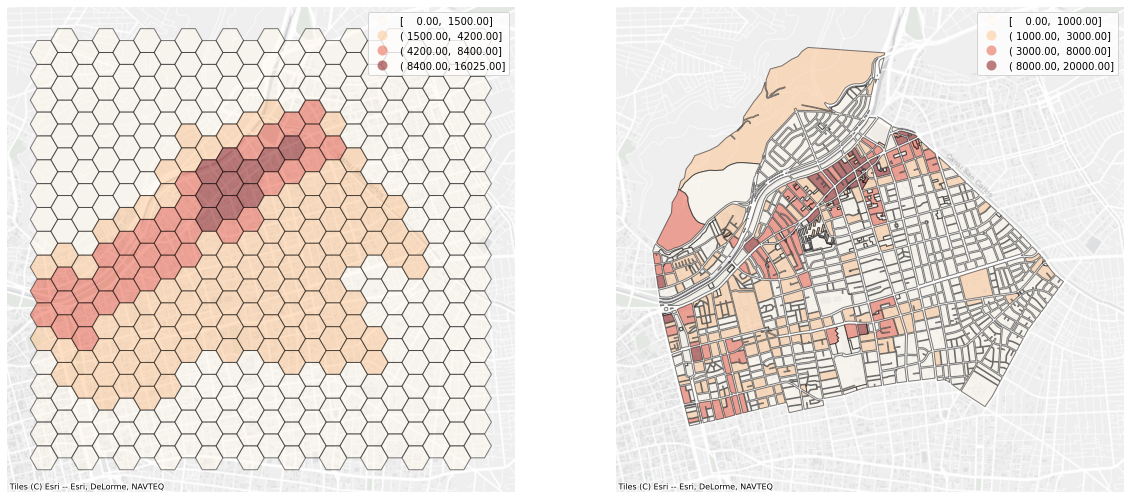

In [12]:
fig, (ax1, ax2) = pyplot.subplots(ncols=2, sharex=True, sharey=True, figsize=(20,20))
celdas_providencia.plot(ax=ax1, column='POBLACIÓN_FLOTANTE_2012', alpha=0.5, edgecolor='k', legend=True, cmap='OrRd', scheme="User_Defined", classification_kwds=dict(bins=[1500,4200,8400,16025]))
gdf_mz_providencia.plot(ax=ax2, column='COMERCIO', alpha=0.5, edgecolor='k', legend=True, cmap='OrRd', scheme="User_Defined", classification_kwds=dict(bins=[1000,3000,8000,20000]))
ctx.add_basemap(ax=ax1, source=ctx.providers.Esri.WorldGrayCanvas)
ctx.add_basemap(ax=ax2, source=ctx.providers.Esri.WorldGrayCanvas)
ax1.set_axis_off()
ax2.set_axis_off()

A partir de las gráficas anteriores, se observa que existe, a priori, una correlación entre la población flotante y el uso de suelo comercial. En efecto, a mayor cantidad de metros cuadrados de uso comercial, se observa una mayor población flotante atraída. Esto sustenta la hipótesis central de esta metodología, que se refiere a que los usos de suelo dentro de la comuna de Providencia definen la distribución de su población flotante respectiva. 

### 7. REGRESIÓN LINEAL

Con el objetivo de validar la hipótesis propuesta y continuar con el desarrollo de la metodología, se procede a elaborar la matriz de correlaciones de las variables del GeoDataFrame celdas_providencia. En específico, se observa que la variable "POBLACIÓN_FLOTANTE" posee una correlación alta con las variables (usos de suelo) "COMERCIO", "HABITACIONAL", "BODEGA, "OFICINA" y "ESTACIONAMIENTOS", y una correlación media con las variables "EDUCACIÓN_CULTURA", "SALUD", y "OTROS". 

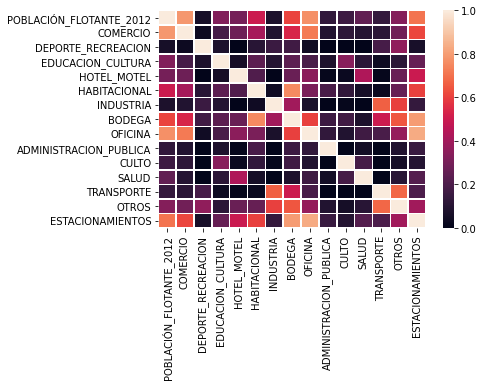

In [13]:
def corr_Matrix (celdas_providencia):
    corr = celdas_providencia[['POBLACIÓN_FLOTANTE_2012','COMERCIO','DEPORTE_RECREACION','EDUCACION_CULTURA','HOTEL_MOTEL','HABITACIONAL','INDUSTRIA','BODEGA','OFICINA','ADMINISTRACION_PUBLICA','CULTO','SALUD','TRANSPORTE','OTROS','ESTACIONAMIENTOS']].corr()
    return sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values,vmin=0,vmax=1,linewidths=.5)

heatmap = corr_Matrix(celdas_providencia)

A partir de estos resultados, se procede a continuación a construir un Modelo de Regresión Lineal Múltiple (MRLM), en el cual buscaremos explicar la variable "POBLACIÓN_FLOTANTE", en función de las variables "COMERCIO", "EDUCACION_CULTURA", "HABITACIONAL", "OFICINA", y "SALUD". Cabe destacar que este estudio consideró el análisis de diversos conjuntos de variables explicativas, siendo escogidas las recién definidas, dado que reportaban la mejor bondad de ajuste, signos consistentes con lo esperado en teoría y significancia estadística al 99% de confianza.

In [14]:
X = celdas_providencia[['COMERCIO','EDUCACION_CULTURA','HABITACIONAL','OFICINA','SALUD']]
y = celdas_providencia['POBLACIÓN_FLOTANTE_2012']

model = sm.OLS(y, X).fit()
predictions = list(model.predict(X)) 
celdas_providencia['ESTIMACION_POBLACIÓN_FLOTANTE_2012'] = model.predict()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     POBLACIÓN_FLOTANTE_2012   R-squared (uncentered):                   0.826
Model:                                 OLS   Adj. R-squared (uncentered):              0.824
Method:                      Least Squares   F-statistic:                              372.0
Date:                     Tue, 12 Jan 2021   Prob (F-statistic):                   3.77e-146
Time:                             13:43:16   Log-Likelihood:                         -3386.1
No. Observations:                      396   AIC:                                      6782.
Df Residuals:                          391   BIC:                                      6802.
Df Model:                                5                                                  
Covariance Type:                 nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
COMERCIO              0.1507      0.014     10.900      0.000       0.124       0.178
EDUCACION_CULTURA     0.1151      0.020      5.734      0.000       0.076       0.155
HABITACIONAL          0.0215      0.002      9.507      0.000       0.017       0.026
OFICINA               0.0568      0.005     10.426      0.000       0.046       0.068
SALUD                 0.0636      0.011      5.612      0.000       0.041       0.086
==============================================================================
Omnibus:                      121.179   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1471.893
Skew:                           0.919   Prob(JB):                         0.00
Kurtosis:                      12.264   Cond. No.                         11.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

A partir de los resultados obtenidos del MRLM, se concluye que un 82,4% de la variación de la población flotante, entre las celdas hexagonales definidas en la comuna de Providencia, se puede explicar a partir de las variaciones de sus respectivos metros cuadrados de uso de suelo comercial, educacional y cultural, habitacional, oficina y sanitario. De ellos, aquellos que poseen la mayor significancia estadística corresponden al uso de suelo comercial y de oficina, lo cual se condice con lo esperado por teoría, dado que consideran directamente la atracción de clientes y trabajadores, respectivamente. 

# Proyección 2020 por SII

In [15]:
df_predios2, df_lineas2 = read_SII(2020)
df_predios2 = info_SII(df_predios2, df_lineas2)
gdf_mz_providencia2 = geom_SII(15103)
gdf_mz_providencia2 = geoInfo_SII(df_predios2, gdf_mz_providencia2)
celdas_providencia2 = cells_Providencia(gdf_mz_providencia2)

In [16]:
celdas_providencia2['ESTIMACION_POBLACIÓN_FLOTANTE_2020'] = np.array(model.params) @ np.array([celdas_providencia2['COMERCIO'],celdas_providencia2['EDUCACION_CULTURA'],celdas_providencia2['HABITACIONAL'],celdas_providencia2['OFICINA'],celdas_providencia2['SALUD']])
celdas_providencia['RESIDUO'] = celdas_providencia['POBLACIÓN_FLOTANTE_2012']-celdas_providencia['ESTIMACION_POBLACIÓN_FLOTANTE_2012']
celdas_providencia2 = pd.merge(celdas_providencia2,celdas_providencia[['cell','RESIDUO']],on='cell', how='left')
celdas_providencia2['ESTIMACION_POBLACIÓN_FLOTANTE_2020'] = celdas_providencia2['ESTIMACION_POBLACIÓN_FLOTANTE_2020']+celdas_providencia2['RESIDUO']
celdas_providencia2.to_file('Outputs/Información_Celdas_2020/Información_Celdas_2020.shp',encoding="utf-8")

In [17]:
celdas_providencia2['ESTIMACION_POBLACIÓN_FLOTANTE_2020'].sum()

747635.660221976